**Installing  and Importing Required Libraries**

In [118]:
!pip install yfinance

In [119]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt

SEED = 10
np.random.seed(SEED)

**ADF TEST**

In [120]:
def get_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data['Adj Close']

In [121]:
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN','TSLA','JPM', 'JNJ', 'V', 'PG', 'UNH']

start_date = '2022-01-01'
end_date = '2023-01-01'
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  10 of 10 completed


In [122]:
df.head(10)

Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,PG,TSLA,UNH,V
Date,,,,,,,,,,
2022-01-03,179.481110,170.404495,144.991501,159.712173,150.404922,327.530090,153.057358,399.926666,486.654755,217.228287
2022-01-04,177.203217,167.522003,144.399506,159.283905,156.106750,321.913879,153.592926,383.196655,475.628723,218.238754
2022-01-05,172.489639,164.356995,137.774994,160.345322,153.252808,309.556335,154.288208,362.706665,474.456451,215.825424
2022-01-06,169.610214,163.253998,137.747498,159.796005,154.880936,307.110229,152.991608,354.899994,455.039856,215.580185
2022-01-07,169.777832,162.554001,137.016998,161.955994,156.415558,307.266785,152.907043,342.320007,444.333557,212.843109
2022-01-10,169.797546,161.485992,138.669495,161.155304,156.565231,307.491791,150.821182,352.706665,450.534454,207.947784
2022-01-11,172.647430,165.362000,139.735992,159.442169,156.724319,308.186493,149.073563,354.799988,454.410034,210.312088
2022-01-12,173.091156,165.207001,141.430496,158.082855,157.613266,311.405548,149.402374,368.739990,458.983215,211.616867
2022-01-13,169.797546,161.214005,138.587006,157.123840,157.416748,298.226044,148.725922,343.853333,452.888885,210.920303


In [123]:
def ADF_TEST(X, stock1, stock2, cutoff = 0.01):
  adf_test = adfuller(residuals)
  if adf_test[1] < 0.01:
      print(f"ADF test statistic: {adf_test[0]}")
      print(f"p-value: {adf_test[1]}")
      print(f"The {stock1} and {stock2} are cointegrated.")

In [124]:
for i in range(len(stocks)):
    for j in range(i+1, len(stocks)):
        Y = df[stocks[i]]
        X = df[stocks[j]]
        #adding column of ones to account for intercept along with slope (like weight and bias)
        X_with_constant = sm.add_constant(X)
        model = OLS(Y, X_with_constant).fit()
        # residuals via regression model
        residuals = Y - model.predict()
        ADF_TEST(residuals,stocks[i], stocks[j])

ADF test statistic: -3.5262865783786297
p-value: 0.007337112251634686
The AAPL and AMZN are cointegrated.
ADF test statistic: -3.7617753365620565
p-value: 0.003323529708052223
The MSFT and GOOGL are cointegrated.
ADF test statistic: -3.8878362224092755
p-value: 0.0021262120317089616
The V and PG are cointegrated.


**V and PG have the lowest pvalue**

In [125]:
st1 = 'V'
st2 = 'PG'
Y = df[st1]
X = df[st2]

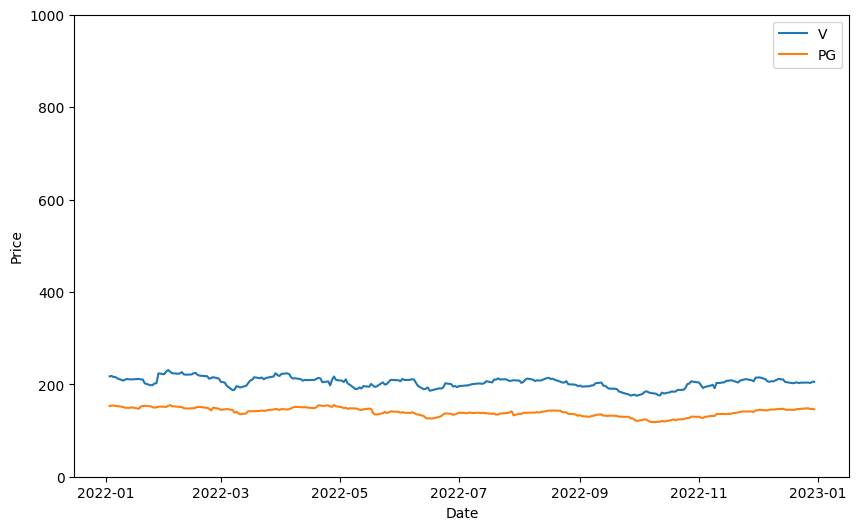

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(df[st1], label=st1)
plt.plot(df[st2], label=st2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.ylim(0,1000)

plt.show()

**Regression Model**

In [127]:
X_with_constant = sm.add_constant(X)
model = OLS(Y,X_with_constant).fit()
print(model.params)

const    67.630999
PG        0.971789
dtype: float64


**Spread Curve**

In [128]:
Residuals = Y - (model.params['const'] + model.params[st2]*X)
print(Residuals.equals(Y-model.predict()))

True


<Axes: xlabel='Date'>

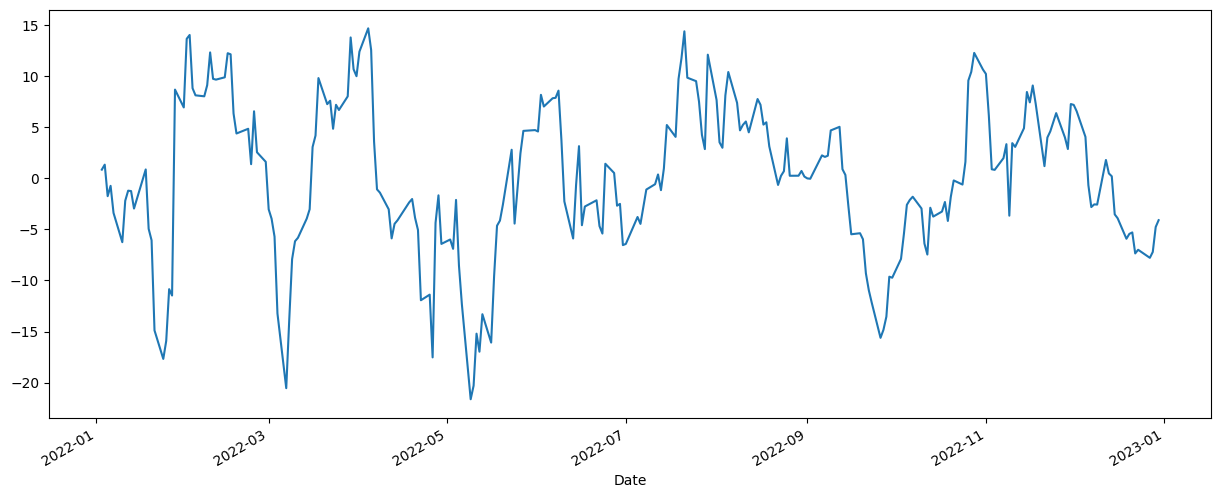

In [129]:
spread = Residuals
spread.plot(figsize=(15,6))

**Normal Distribution Curve**

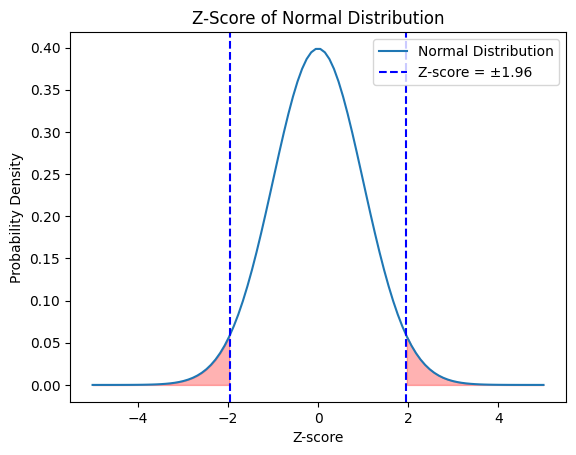

In [130]:
from scipy.stats import norm
x = np.linspace(-5, 5, 100)
# computing pdf for normal distribution
y = norm.pdf(x, loc=0, scale=1)
fig, ax = plt.subplots()
ax.plot(x, y, label='Normal Distribution')
# Shading Area corresponding to z-scores >= 1.96 and <= -1.96
z_critical = 1.96
ax.fill_between(x, y, where=(x >= z_critical), color='red', alpha=0.3)
ax.fill_between(x, y, where=(x <= -z_critical), color='red', alpha=0.3)

ax.set_xlabel('Z-score')
ax.set_ylabel('Probability Density')
ax.set_title('Z-Score of Normal Distribution')
ax.axvline(x=z_critical, linestyle='--', color='blue', label='Z-score = ±1.96')
ax.axvline(x=-z_critical, linestyle='--', color='blue')
ax.legend()
plt.show()

**Z-Score**

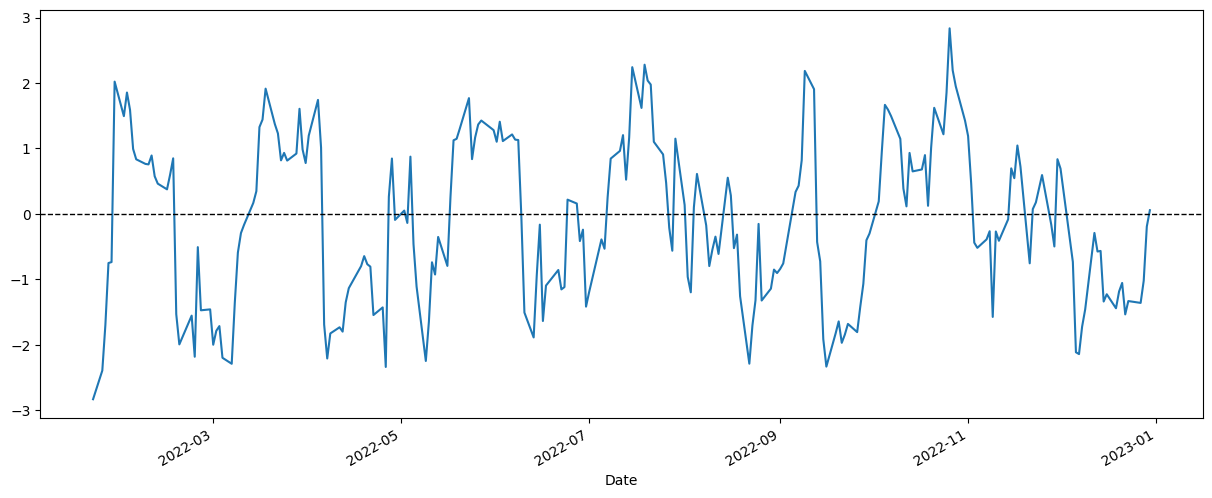

In [131]:
window_size = 14
spread_mean = spread.rolling(window = window_size).mean()
spread_std_dev = spread.rolling(window=window_size).std()
z_score = (spread-spread_mean)/spread_std_dev
z_score.plot(figsize=(15,6))
plt.axhline(y=0, color='k', linestyle='--', linewidth=1, label='Z=0')

In [132]:
z_score

Date
2022-01-03         NaN
2022-01-04         NaN
2022-01-05         NaN
2022-01-06         NaN
2022-01-07         NaN
                ...   
2022-12-23   -1.331611
2022-12-27   -1.359948
2022-12-28   -1.020689
2022-12-29   -0.192905
2022-12-30    0.056855
Length: 251, dtype: float64

**Finding first non 'Nan' datapoint**

In [133]:
first_valid_idx = z_score.first_valid_index()
z_score = z_score[first_valid_idx:]
z_score

Date
2022-01-21   -2.832221
2022-01-24   -2.393840
2022-01-25   -1.695187
2022-01-26   -0.750552
2022-01-27   -0.735867
                ...   
2022-12-23   -1.331611
2022-12-27   -1.359948
2022-12-28   -1.020689
2022-12-29   -0.192905
2022-12-30    0.056855
Length: 238, dtype: float64

**Finding Trading days with following strategy**


1.   If zscore > 2, going long on underpriced and short on overprices and vice-versa for zscore<-2.
2.   Exiting trade for |z| < 1


In [134]:
entry = 2.0
exit = 1.0
# For storing buy and sell positions
stock1_position = pd.Series(data=0, index=z_score.index)
stock2_position = pd.Series(data=0, index=z_score.index)


for i in range(1, len(z_score)):
    # zscore<-2 and without previous long position for stock 1
    if z_score[i] < -entry and stock1_position[i-1] == 0:
        stock1_position[i] = 1 # long stock 1
        stock2_position[i] = -1 # short stock 2

    # zscore>2 without previous short position for stock 2
    elif z_score[i] > entry and stock2_position[i-1] == 0:
        stock1_position[i] = -1 # short stock 1
        stock2_position[i] = 1 # long stock 2
    # for exiting trade
    elif abs(z_score[i]) < exit:
        stock1_position[i]= 0
        stock2_position[i]= 0
    #continuing the previous position
    else:
        stock1_position[i]=stock1_position[i-1]
        stock2_position[i]=stock2_position[i-1]

**Plotting trading days buy and sell signal**

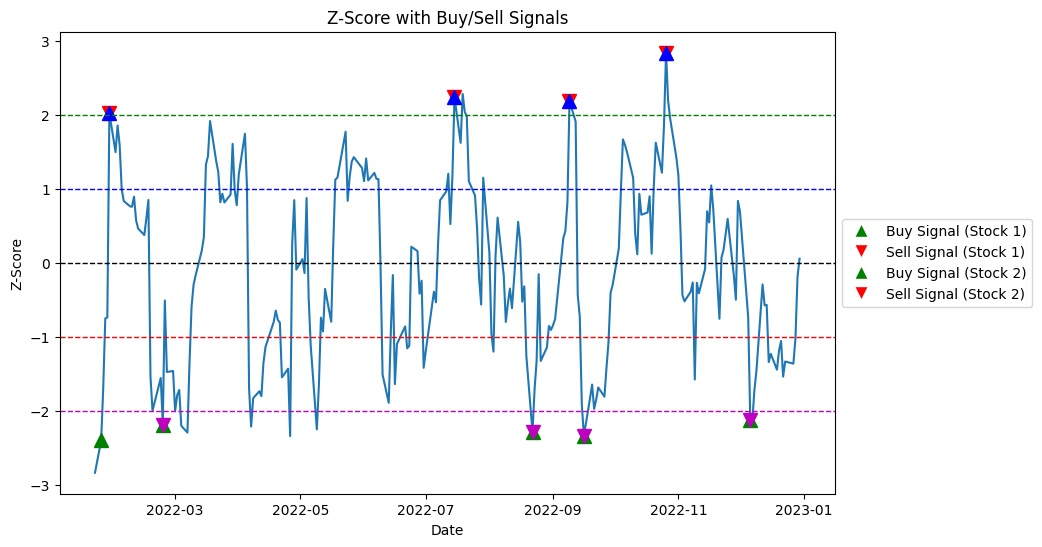

In [135]:
from matplotlib.lines import Line2D

# Plotting z-score
plt.figure(figsize=(10, 6))
plt.plot(z_score.index, z_score, label='Z-Score')

#Tracking trade status
in_trade_stock1 = False
in_trade_stock2 = False

# Lists to store legend labels and handles
legend_labels = set()
legend_handles = []

# Plotting buy and sell signals for stock 1
for i in range(len(stock1_position)):
    if stock1_position[i] == 1 and not in_trade_stock1:
        plt.plot(stock1_position.index[i], z_score[i], '^', markersize=10, color='g')
        legend_labels.add('Buy Signal (Stock 1)')
        legend_handles.append(Line2D([0], [0], marker='^', color='w', markersize=10, markerfacecolor='g'))
        in_trade_stock1 = True
    elif stock1_position[i] == -1 and in_trade_stock1:
        plt.plot(stock1_position.index[i], z_score[i], 'v', markersize=10, color='r')
        legend_labels.add('Sell Signal (Stock 1)')
        legend_handles.append(Line2D([0], [0], marker='v', color='w', markersize=10, markerfacecolor='r'))
        in_trade_stock1 = False

# Plotting buy and sell signals for stock 2
for i in range(len(stock2_position)):
    if stock2_position[i] == 1 and not in_trade_stock2:
        plt.plot(stock2_position.index[i], z_score[i], '^', markersize=10, color='b')
        legend_labels.add('Buy Signal (Stock 2)')
        legend_handles.append(Line2D([0], [0], marker='^', color='w', markersize=10, markerfacecolor='b'))
        in_trade_stock2 = True
    elif stock2_position[i] == -1 and in_trade_stock2:
        plt.plot(stock2_position.index[i], z_score[i], 'v', markersize=10, color='m')
        legend_labels.add('Sell Signal (Stock 2)')
        legend_handles.append(Line2D([0], [0], marker='v', color='w', markersize=10, markerfacecolor='m'))
        in_trade_stock2 = False


plt.axhline(y=0, color='k', linestyle='--', linewidth=1, label='Z=0')
plt.axhline(y=1, color='b', linestyle='--', linewidth=1, label='Z=1')
plt.axhline(y=-1, color='r', linestyle='--', linewidth=1, label='Z=-1')
plt.axhline(y=2, color='g', linestyle='--', linewidth=1, label='Z=2')
plt.axhline(y=-2, color='m', linestyle='--', linewidth=1, label='Z=-2')
plt.legend(legend_handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Z-Score with Buy/Sell Signals')
plt.show()


**Calculating Cumulative Returns**

<Axes: xlabel='Date'>

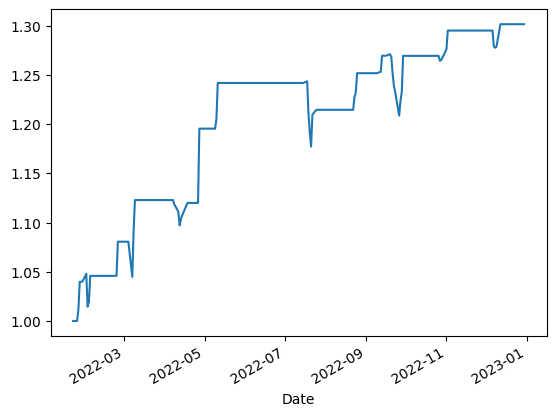

In [136]:
stock1_returns = (df[st1][first_valid_idx:].pct_change() * stock1_position.shift(1)).fillna(0)
stock2_returns = (df[st2][first_valid_idx:].pct_change() * stock2_position.shift(1)).fillna(0)
# calculate the total returns of the strategy
total_returns = stock1_returns + stock2_returns
cumulative_returns = (1 + total_returns).cumprod()
# plot the cumulative returns
cumulative_returns.plot()

**Total Return**

In [139]:
print(f" Net Return by Pair trading on {st1} and {st2} is {((cumulative_returns[-1]-1)*100).round(2)}%")

 Net Return by Pair trading on V and PG is 30.15%
